# Imports

In [1]:
# %matplotlib notebook

In [1]:
!pip install umap-learn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.manifold import TSNE

from sklearn.neighbors import LocalOutlierFactor as LOF
from sklearn.ensemble import IsolationForest as IF
from sklearn.manifold import LocallyLinearEmbedding,MDS,Isomap
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, silhouette_score

import umap
from ipywidgets import interact

from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, SpectralClustering, AgglomerativeClustering, HDBSCAN
from sklearn.mixture import GaussianMixture


https://www.kaggle.com/datasets/ghoshsaibal/creditcard

# Analiza

## Ucitavanje podataka

In [4]:
def csv_to_pd(path):
    return pd.read_csv(path)

def pandas_uniques(df, col_name):
    counts = df[col_name].value_counts()
    unique = df[col_name].unique()
    return unique,counts

def print_uniques(df, cols, count_per_categ=False):
    for c in cols:
        print()
        print(c)
        print("-----------------")
        u, b = pandas_uniques(df,c)
        print("\tVrednosti: ",u)
        print("\tBroj jedinstvenih: ",len(u))
    
        if not count_per_categ: continue
        print("\tJedinstvenih:")
        for i in range(len(b)):
            print("\t",b.iloc[i])

In [5]:
applications = csv_to_pd("./data/application_record.csv")
credits = csv_to_pd("./data/credit_record.csv")

In [9]:
applications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [7]:
cols = ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',\
        'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']\

print_uniques(applications,cols)


CODE_GENDER
-----------------
	Vrednosti:  ['M' 'F']
	Broj jedinstvenih:  2

FLAG_OWN_CAR
-----------------
	Vrednosti:  ['Y' 'N']
	Broj jedinstvenih:  2

FLAG_OWN_REALTY
-----------------
	Vrednosti:  ['Y' 'N']
	Broj jedinstvenih:  2

NAME_INCOME_TYPE
-----------------
	Vrednosti:  ['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']
	Broj jedinstvenih:  5

NAME_EDUCATION_TYPE
-----------------
	Vrednosti:  ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
	Broj jedinstvenih:  5

NAME_FAMILY_STATUS
-----------------
	Vrednosti:  ['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']
	Broj jedinstvenih:  5

NAME_HOUSING_TYPE
-----------------
	Vrednosti:  ['Rented apartment' 'House / apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']
	Broj jedinstvenih:  6

OCCUPATION_TYPE
-----------------
	Vrednosti:  [nan 'Security staff' 'Sales staff' 'Accountants' '

In [10]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [11]:
cols = ['STATUS']
print_uniques(credits,cols)


STATUS
-----------------
	Vrednosti:  ['X' '0' 'C' '1' '2' '3' '4' '5']
	Broj jedinstvenih:  8


## Enkodiranje

In [12]:
def encode_column(df, col_spec):
    df_enc = df.copy()
    for (c, is_one_hot) in col_spec:
        if is_one_hot:
            df_enc = pd.get_dummies(df_enc, columns=[c], dtype=int)
            continue
        le = LabelEncoder()
        le.fit(df_enc[c])
        df_enc[c] = le.transform(df_enc[c])
    return df_enc

def encode_with_dict(df, col, enc_dict):
    df_enc = df.copy()
    df_enc[col] = df_enc[col].apply(lambda x: enc_dict[x])
    return df_enc

In [13]:
cols = [('CODE_GENDER',False),\
        ('FLAG_OWN_CAR',False),\
        ('FLAG_OWN_REALTY',False),\
        ('NAME_INCOME_TYPE',True),\
        ('NAME_EDUCATION_TYPE',False),\
        ('NAME_FAMILY_STATUS', True),\
        ('NAME_HOUSING_TYPE',True),\
        ('OCCUPATION_TYPE',True)]
applications = encode_column(applications, cols)

enc_dict = {'X':-2, 'C':-1, '0':0, '1':1, '2':2, '3':3, '4':4, '5':5}
cred_enc = encode_with_dict(credits, 'STATUS', enc_dict)

## Feature Engineering

In [14]:
applications.describe()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,...,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
count,4.385570e+05,438557.000000,438557.000000,438557.000000,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.000000,438557.0,...,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.328616,0.371897,0.693351,0.427390,1.875243e+05,3.116268,-15997.904649,60563.675328,1.0,...,0.178403,0.004880,0.080918,0.030828,0.007880,0.002374,0.093712,0.004661,0.018226,0.003797
std,5.716370e+05,0.469711,0.483312,0.461103,0.724882,1.100869e+05,1.336736,4185.030007,138767.799647,0.0,...,0.382852,0.069684,0.272709,0.172853,0.088421,0.048663,0.291428,0.068110,0.133767,0.061499
min,5.008804e+06,0.000000,0.000000,0.000000,0.000000,2.610000e+04,0.000000,-25201.000000,-17531.000000,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.609375e+06,0.000000,0.000000,0.000000,0.000000,1.215000e+05,1.000000,-19483.000000,-3103.000000,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.047745e+06,0.000000,0.000000,1.000000,0.000000,1.607805e+05,4.000000,-15630.000000,-1467.000000,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.456971e+06,1.000000,1.000000,1.000000,1.000000,2.250000e+05,4.000000,-12514.000000,-371.000000,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.999952e+06,1.000000,1.000000,1.000000,19.000000,6.750000e+06,4.000000,-7489.000000,365243.000000,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
# Podelimo zaradu u grupe 
# 20 - 260k na po 20k, sve preko je jedna grupa
def get_bucket(number, bucket_size, max_value, red_one):
    number = min(number,max_value)
    s = number//bucket_size
    return s - 1 if red_one else s

In [16]:
# Dane od rodjenja, dane zaposljenja prevedemo u godine
applications['DAYS_OLD'] = -applications['DAYS_BIRTH']
applications['DAYS_WORKING'] = applications['DAYS_EMPLOYED'].apply(lambda x: -x if x<0 else 0)
applications['INCOME_BRACKET'] = applications['AMT_INCOME_TOTAL'].apply(lambda x: get_bucket(x,20000,1000000,False))

In [17]:
applications.drop(['DAYS_BIRTH','DAYS_EMPLOYED'],axis=1, inplace=True)

In [18]:
applications.describe()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,...,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,DAYS_OLD,DAYS_WORKING,INCOME_BRACKET
count,4.385570e+05,438557.000000,438557.000000,438557.000000,438557.000000,4.385570e+05,438557.000000,438557.0,438557.000000,438557.000000,...,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.328616,0.371897,0.693351,0.427390,1.875243e+05,3.116268,1.0,0.206133,0.287771,...,0.030828,0.007880,0.002374,0.093712,0.004661,0.018226,0.003797,15997.904649,2172.502516,8.881479
std,5.716370e+05,0.469711,0.483312,0.461103,0.724882,1.100869e+05,1.336736,0.0,0.404527,0.452724,...,0.172853,0.088421,0.048663,0.291428,0.068110,0.133767,0.061499,4185.030007,2397.398738,5.013303
min,5.008804e+06,0.000000,0.000000,0.000000,0.000000,2.610000e+04,0.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7489.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,0.000000,0.000000,0.000000,1.215000e+05,1.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12514.000000,371.000000,6.000000
50%,6.047745e+06,0.000000,0.000000,1.000000,0.000000,1.607805e+05,4.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15630.000000,1467.000000,8.000000
75%,6.456971e+06,1.000000,1.000000,1.000000,1.000000,2.250000e+05,4.000000,1.0,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19483.000000,3103.000000,11.000000
max,7.999952e+06,1.000000,1.000000,1.000000,19.000000,6.750000e+06,4.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,25201.000000,17531.000000,50.000000


## Outlieri

In [19]:
isf = IF(n_estimators=200, n_jobs=-1)
pred1 = isf.fit_predict(applications)
c = (pred1<0).sum()
print("Outliers: ",c)

Outliers:  22773


In [20]:
lof = LOF(n_neighbors=30, n_jobs=-1)
pred2 = lof.fit_predict(applications)
c = (pred2<0).sum()
print("Outliers: ",c)

Outliers:  31083


In [21]:
outliers=[]
for i in range(len(pred1)):
    if pred1[i]==pred2[i] and pred1[i]==-1:
        outliers.append(i)
print("Outliers: ", len(outliers))

Outliers:  2008


In [22]:
applications.drop(outliers, inplace=True)

## Prikaz

In [21]:
def plot_sub(data, axes, i, j, binwidth, color,title=None):
    m = np.mean(data)
    v = np.var(data)
    ax = get_ax(axes,i,j)

    sns.histplot(data = data, binwidth = binwidth, ax = ax, color=color, legend=False)
    
    ax.axvline(m, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {m:.2f}')
    ax.axvline(m - np.sqrt(v), color='green', linestyle='dashed', linewidth=2, label=f'-1 SD')
    ax.axvline(m + np.sqrt(v), color='green', linestyle='dashed', linewidth=2, label=f'+1 SD')

    if not title is None:
        ax.set_title(title)

def plot_pie(data, ax,col):
    labels = data.unique()
    counts = data.value_counts()
    ax.pie(counts,labels=labels,autopct='%1.1f%%')
    ax.set_title(col)

def get_ax(axes, i, j):
    if not hasattr(axes,'shape'):
        return axes
    elif len(axes.shape) == 1:
        return axes[i]
    else:
        return axes[i,j]
    
def get_plot_w_h(plot_count):
    w = int(plot_count**0.5)
    h = plot_count //w
    if plot_count%w !=0:
        h+=1
    return w,h

def plot_features(X, col_list, plot_w, plot_h):
    #col_list - kolona, sirina binova, boja
    plot_count = len(col_list)
    w,h = get_plot_w_h(plot_count)
    fig, axes = plt.subplots(h, w, figsize = (plot_h,plot_w))
    
    for i in range(h):
        for j in range(w):
            ind = i*w + j
            if ind >= plot_count:
                break
            col, bins, color = col_list[ind]
            plot_sub(X[col], axes, i, j, bins, color)
    plt.tight_layout()
    plt.show()

def plot_pie_charts(X, col_list, plot_w, plot_h):
    plot_count = len(col_list)
    w,h = get_plot_w_h(plot_count)
    fig, axes = plt.subplots(h, w, figsize = (plot_h,plot_w))
    
    for i in range(h):
        for j in range(w):
            ind = i*w + j
            if ind >= plot_count:
                break
            col = col_list[ind]
            plot_pie(X[col], get_ax(axes, i, j),col)
    plt.tight_layout()
    plt.show()

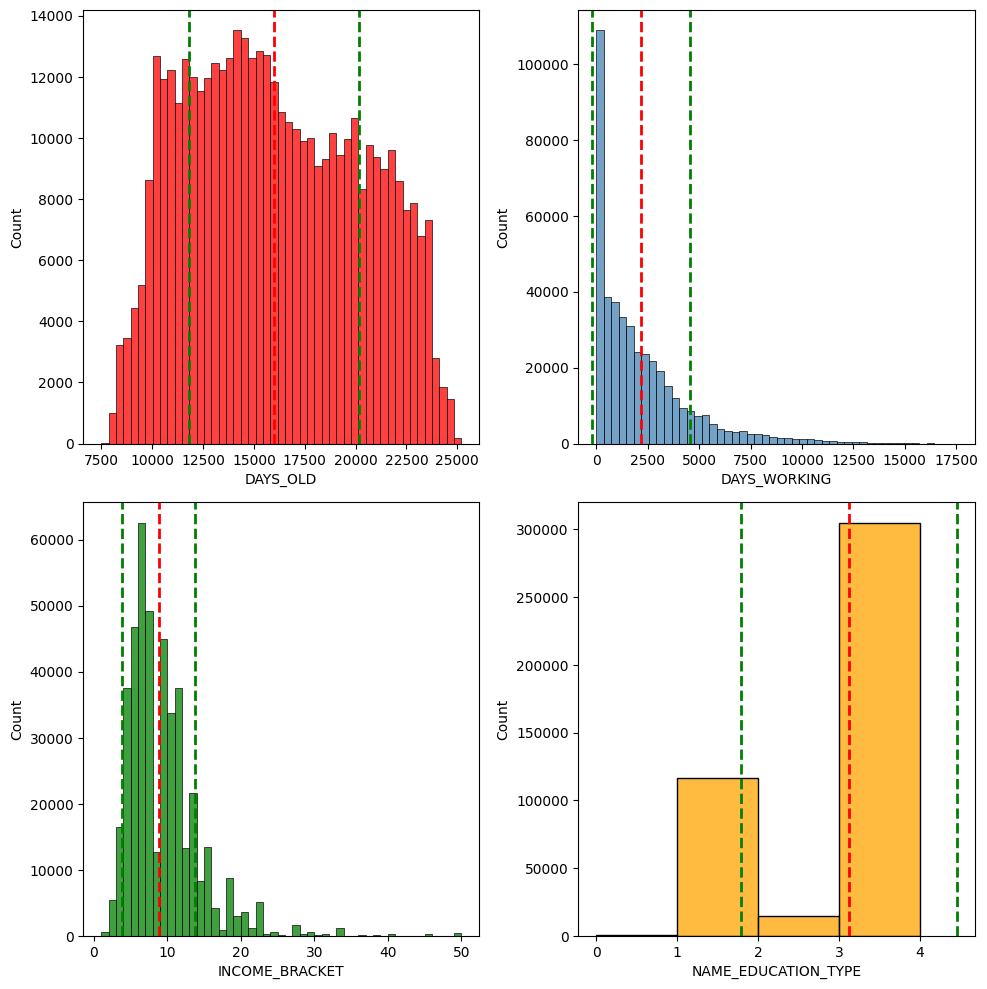

In [22]:
col_list = [('DAYS_OLD',365,'red'),\
            ('DAYS_WORKING',365,'steelblue'),\
            ('INCOME_BRACKET',1,'green'),\
            ('NAME_EDUCATION_TYPE',1,'orange')]
plot_features(applications,col_list,10,10)

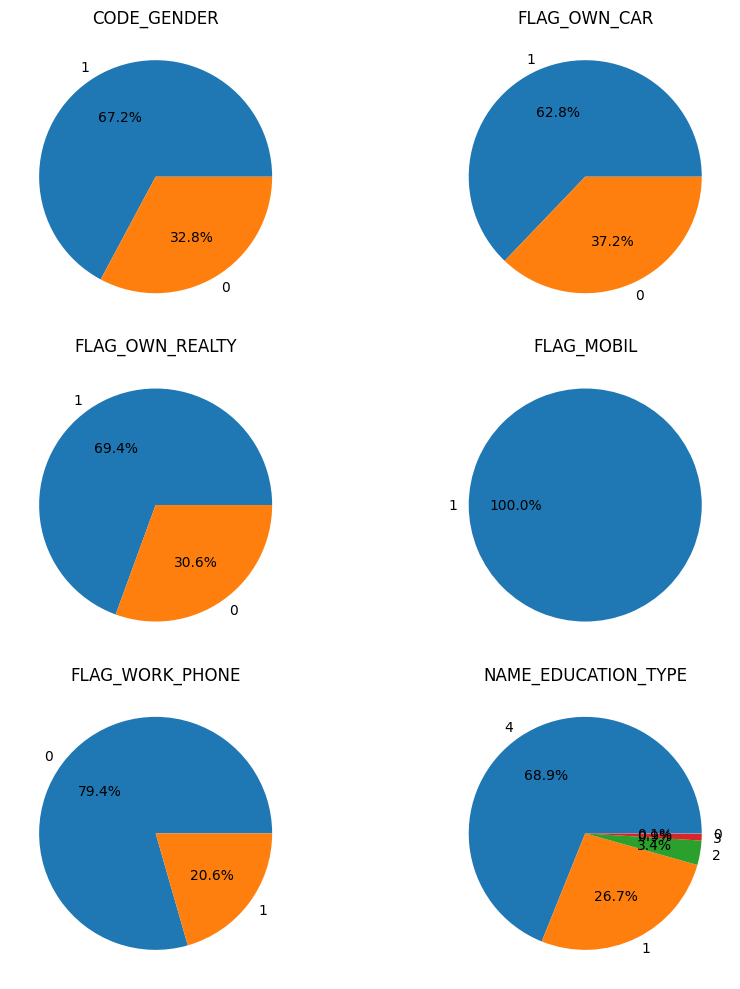

In [23]:
col_list = ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','FLAG_MOBIL','FLAG_WORK_PHONE','NAME_EDUCATION_TYPE']
plot_pie_charts(applications,col_list,10,10)

# Odredjivanje grupe korisnika

In [23]:
#Nadjemo istoriju placanje za one korisnike ciji ID je u obe tabele
payment_history = cred_enc[cred_enc['ID'].isin(applications['ID'])]
#Za svakog korisnika nadjemo status otplate za svaki od meseca, sortiramo i uzmemo samo najnovije podatke
last_pay_dict = payment_history.groupby('ID').apply(lambda x: sorted(zip(x['MONTHS_BALANCE'], x['STATUS']),reverse=True)[0][1]).to_dict()
avg_pay_dict = payment_history.groupby('ID').apply(lambda x: sorted(zip(x['MONTHS_BALANCE'], x['STATUS']),reverse=True)).to_dict()

In [24]:
def get_avg_pay(pay_dict):
    for i in pay_dict.keys():
        l = pay_dict[i]
        tot_w = 0
        s = 0
        for j in range(len(l)):
            w = 1/(j+1)
            s += w * l[j][1]
            tot_w += w
        pay_dict[i] = int(s / tot_w)
    return pay_dict
avg = list(get_avg_pay(avg_pay_dict).values())
last = list(last_pay_dict.values())

In [25]:
ids = list(last_pay_dict.keys())

In [26]:
apps_with_paydata = applications[applications['ID'].isin(ids)]

## Skaliranje

In [27]:
ss = StandardScaler()
apps_with_paydata = ss.fit_transform(apps_with_paydata)

# Redukcija dimenzionalnosti

In [28]:
def get_alg(alg_type, n_components):
    if alg_type=="PCA":
        return PCA(n_components=n_components)
    elif alg_type=="GRP":
        return GaussianRandomProjection(n_components=n_components)
    elif alg_type=="LLE":
        return LocallyLinearEmbedding(n_components=n_components,n_jobs=-1, n_neighbors=10, eigen_solver='dense')
    elif alg_type=="ISO":
        return Isomap(n_components=n_components,n_jobs=-1, n_neighbors=15)
    elif alg_type=="MDS":
        return MDS(n_components=n_components,n_jobs=-1, normalized_stress=False)
    elif alg_type=="UMAP":
        return umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=n_components, n_jobs=-1)
    else:
        print("Unknown algorithm...")
        return PCA(n_components=n_components)
def plot_dict(data):
    df = pd.DataFrame(list(data.items()), columns=['Timestamp', 'Metric'])
    sns.lineplot(x='Timestamp', y='Metric', data=df)
    
def plot_n_comp(data, alg_type, start_comp, end_comp, step, samples=None):
    i = start_comp
    results = {}
    s = time.time()
        
    while i<=end_comp:
        alg = get_alg(alg_type, i)
        s1 = time.time()
        if samples is not None:
            alg.fit(data[:samples])
        else:
            alg.fit(data)
        e1 = time.time()
        rec_loss = 0
        if hasattr(alg, "inverse_transform"):
            transformed = alg.transform(data)
            data_reconstructed = alg.inverse_transform(transformed)
            rec_loss = mean_squared_error(data, data_reconstructed)
        elif hasattr(alg, "reconstruction_error"):
            rec_loss = alg.reconstruction_error()
        elif hasattr(alg, "reconstruction_error_"):
            rec_loss = alg.reconstruction_error_
        elif hasattr(alg, "stress_"):
            rec_loss = alg.stress_
        else:
            print("Unknown dim reduction metric")
        results[i] = abs(rec_loss)
        print(alg_type," - Dimensions: ",i,"\tReconstruction error: ", abs(rec_loss), "\tFit time: ", (e1-s1),"s")
        i+=step
    e = time.time()
    print("Total time: ",(e-s), "s")
    plot_dict(results)

def plot_size_comp(data, n, alg_type, start_size, end_size, step):
    i = start_size
    results = {}
    s = time.time()
        
    while i<=end_size:
        alg = get_alg(alg_type, n)
        s1 = time.time()
        try:
            alg.fit(data[:i])
        except:
            print("No more memory!")
            break

        e1 = time.time()
        rec_loss = 0
        if hasattr(alg, "inverse_transform"):
            transformed = alg.transform(data)
            data_reconstructed = alg.inverse_transform(transformed)
            rec_loss = mean_squared_error(data, data_reconstructed)
        elif hasattr(alg, "reconstruction_error"):
            rec_loss = alg.reconstruction_error()
        elif hasattr(alg, "reconstruction_error_"):
            rec_loss = alg.reconstruction_error_
        elif hasattr(alg, "stress_"):
            rec_loss = alg.stress_
        else:
            print("Unknown dim reduction metric")
        results[i] = abs(rec_loss)
        print(alg_type," - Samples: ",i,"\tReconstruction error: ", abs(rec_loss), "\tFit time: ", (e1-s1),"s")
        i+=step
    e = time.time()
    print("Total time: ",(e-s), "s")
    plot_dict(results)

## PCA

PCA  - Dimensions:  10 	Reconstruction error:  0.6036034509951674 	Fit time:  0.13551878929138184 s
PCA  - Dimensions:  15 	Reconstruction error:  0.4913619946076556 	Fit time:  0.13800287246704102 s
PCA  - Dimensions:  20 	Reconstruction error:  0.38565081647764377 	Fit time:  0.1590728759765625 s
PCA  - Dimensions:  25 	Reconstruction error:  0.2815697077134286 	Fit time:  0.18714308738708496 s
PCA  - Dimensions:  30 	Reconstruction error:  0.18011078351698015 	Fit time:  0.20979833602905273 s
PCA  - Dimensions:  35 	Reconstruction error:  0.08904277001980941 	Fit time:  0.22626662254333496 s
PCA  - Dimensions:  40 	Reconstruction error:  0.018400665916484704 	Fit time:  0.08586263656616211 s
PCA  - Dimensions:  45 	Reconstruction error:  2.987672421282892e-30 	Fit time:  0.08799576759338379 s
Total time:  1.5529792308807373 s


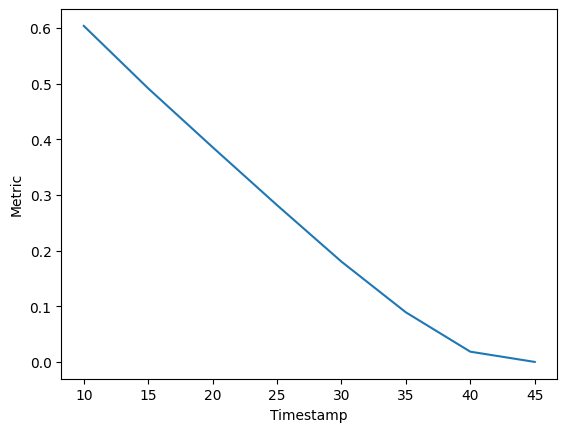

In [29]:
plot_n_comp(apps_with_paydata,"PCA", 10,45,5)

In [30]:
pca = PCA(n_components=40)
pca.fit(apps_with_paydata)
app_train_pca = pca.transform(apps_with_paydata)

## GaussianRandomProjection

GRP  - Dimensions:  10 	Reconstruction error:  0.7686708105594091 	Fit time:  0.016930103302001953 s
GRP  - Dimensions:  15 	Reconstruction error:  0.6713658189877652 	Fit time:  0.002200603485107422 s
GRP  - Dimensions:  20 	Reconstruction error:  0.5791711676693497 	Fit time:  0.002002239227294922 s
GRP  - Dimensions:  25 	Reconstruction error:  0.4883850684329317 	Fit time:  0.0023102760314941406 s
GRP  - Dimensions:  30 	Reconstruction error:  0.37677402593067716 	Fit time:  0.0028400421142578125 s
GRP  - Dimensions:  35 	Reconstruction error:  0.27713180468489695 	Fit time:  0.0023756027221679688 s
GRP  - Dimensions:  40 	Reconstruction error:  0.17157707217562151 	Fit time:  0.0007772445678710938 s
GRP  - Dimensions:  45 	Reconstruction error:  0.08018690072843819 	Fit time:  0.0007216930389404297 s
Total time:  0.28011631965637207 s


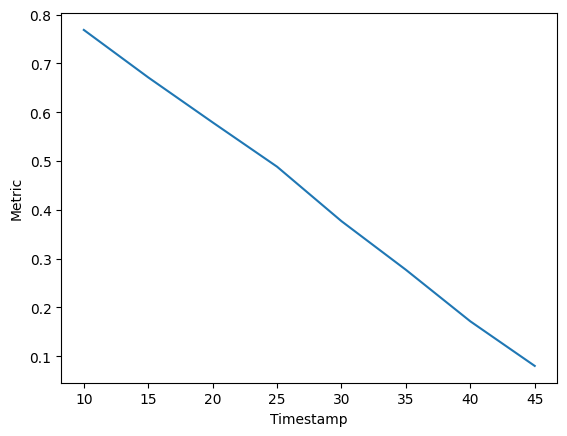

In [31]:
plot_n_comp(apps_with_paydata,"GRP", 10,45,5)

## Locally Linear Embedding

LLE  - Dimensions:  2 	Reconstruction error:  1.5329628607566987e-15 	Fit time:  3.2395167350769043 s
LLE  - Dimensions:  3 	Reconstruction error:  2.299444291135048e-15 	Fit time:  3.182772636413574 s
LLE  - Dimensions:  4 	Reconstruction error:  3.0659257215133974e-15 	Fit time:  3.04520320892334 s
LLE  - Dimensions:  5 	Reconstruction error:  3.832407151891747e-15 	Fit time:  3.0233848094940186 s
LLE  - Dimensions:  6 	Reconstruction error:  4.598888582270096e-15 	Fit time:  3.0125203132629395 s
LLE  - Dimensions:  7 	Reconstruction error:  5.365370012648445e-15 	Fit time:  3.042768716812134 s
LLE  - Dimensions:  8 	Reconstruction error:  6.131851443026795e-15 	Fit time:  3.021719217300415 s
LLE  - Dimensions:  9 	Reconstruction error:  6.898332873405144e-15 	Fit time:  3.0220770835876465 s
LLE  - Dimensions:  10 	Reconstruction error:  7.664814303783494e-15 	Fit time:  3.0469753742218018 s
LLE  - Dimensions:  11 	Reconstruction error:  8.431295734161843e-15 	Fit time:  3.0469739437

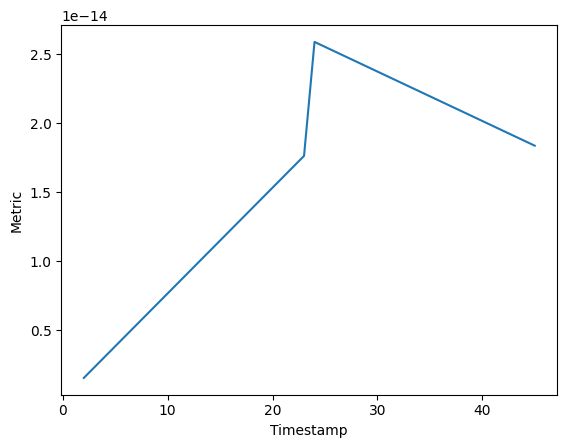

In [32]:
plot_n_comp(apps_with_paydata,"LLE", 2, 45, 1, 3000)

LLE  - Samples:  1000 	Reconstruction error:  1.6350004200934901e-15 	Fit time:  0.4249293804168701 s
LLE  - Samples:  4000 	Reconstruction error:  3.13474518138967e-15 	Fit time:  5.773872137069702 s
LLE  - Samples:  7000 	Reconstruction error:  1.1344969034927524e-15 	Fit time:  22.356585025787354 s
LLE  - Samples:  10000 	Reconstruction error:  1.977450698671026e-15 	Fit time:  57.12127494812012 s
LLE  - Samples:  13000 	Reconstruction error:  4.22713367825648e-15 	Fit time:  118.42883086204529 s
LLE  - Samples:  16000 	Reconstruction error:  4.039369696003425e-15 	Fit time:  213.41818714141846 s
Total time:  417.5266807079315 s


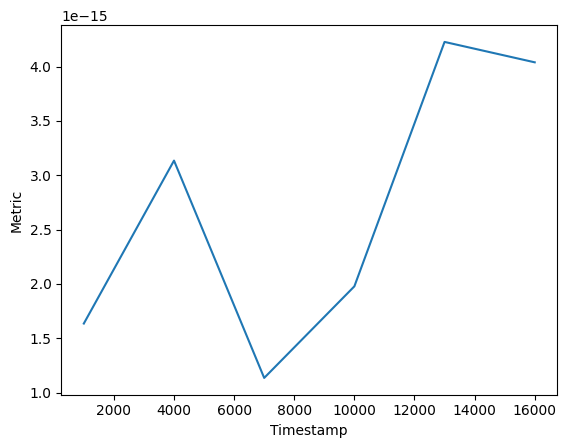

In [33]:
plot_size_comp(apps_with_paydata,2,"LLE",1000,16000,3000)

In [34]:
LLE = LocallyLinearEmbedding(n_components = 40 ,n_jobs=-1, n_neighbors=20, eigen_solver='dense')
LLE.fit(apps_with_paydata)
print(LLE.reconstruction_error_)

-2.002042539626829e-14


In [35]:
app_train_lle = LLE.transform(apps_with_paydata)

## Isomap

C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 10 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of 

ISO  - Dimensions:  3 	Reconstruction error:  169.60226408342555 	Fit time:  9.444180011749268 s


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 10 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of 

ISO  - Dimensions:  8 	Reconstruction error:  95.81476763851498 	Fit time:  9.02425765991211 s


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 10 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of 

ISO  - Dimensions:  13 	Reconstruction error:  83.92223878946588 	Fit time:  18.106727361679077 s


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 10 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of 

ISO  - Dimensions:  18 	Reconstruction error:  81.16971354501484 	Fit time:  18.191667079925537 s


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 10 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of 

ISO  - Dimensions:  23 	Reconstruction error:  79.82951669338634 	Fit time:  18.12864851951599 s


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 10 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of 

ISO  - Dimensions:  28 	Reconstruction error:  79.07578653512584 	Fit time:  18.129898071289062 s


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 10 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of 

ISO  - Dimensions:  33 	Reconstruction error:  78.6170640472001 	Fit time:  18.206761837005615 s


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 10 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of 

ISO  - Dimensions:  38 	Reconstruction error:  78.3234540861821 	Fit time:  18.202250480651855 s
Total time:  130.62260818481445 s


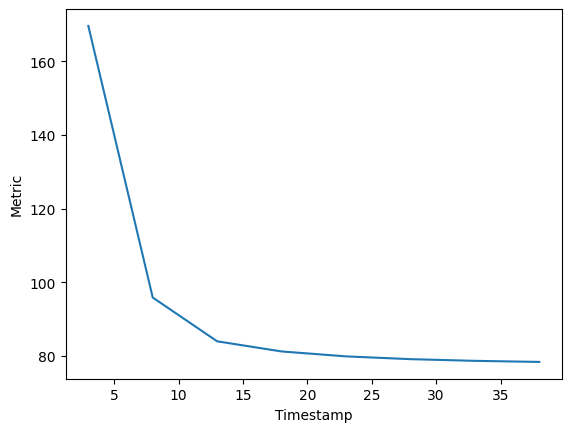

In [36]:
plot_n_comp(apps_with_paydata,"ISO", 3, 40, 5, 5000)

## MDS

MDS  - Dimensions:  3 	Reconstruction error:  2588066.1828689487 	Fit time:  15.463017702102661 s
MDS  - Dimensions:  8 	Reconstruction error:  503942.94480904954 	Fit time:  14.271328687667847 s
MDS  - Dimensions:  13 	Reconstruction error:  194255.71256717766 	Fit time:  14.593568325042725 s
MDS  - Dimensions:  18 	Reconstruction error:  87049.22266151971 	Fit time:  13.94938611984253 s
MDS  - Dimensions:  23 	Reconstruction error:  44885.61055123098 	Fit time:  14.223381757736206 s
MDS  - Dimensions:  28 	Reconstruction error:  26886.556095090244 	Fit time:  13.988924980163574 s
MDS  - Dimensions:  33 	Reconstruction error:  20041.32019551448 	Fit time:  14.137638807296753 s
MDS  - Dimensions:  38 	Reconstruction error:  15208.48565409348 	Fit time:  14.145089626312256 s
Total time:  114.77642560005188 s


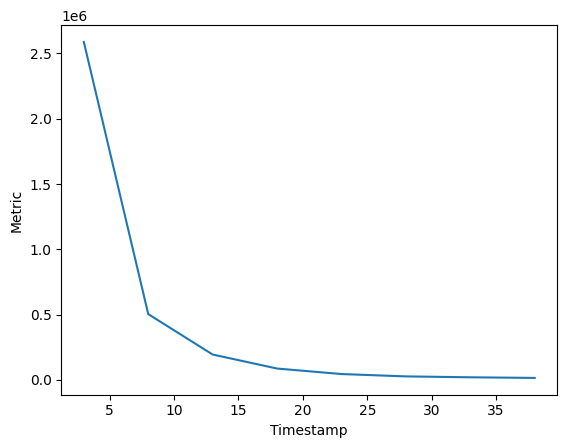

In [37]:
plot_n_comp(apps_with_paydata,"MDS", 3,40, 5, 1000)

## UMAP

In [38]:
plot_n_comp(apps_with_paydata, "UMAP", 2, 40, 1)

C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:392: UserWarning: Exited postprocessing with accuracies 
[2.40240868e-15 3.88444209e-07 3.13484451e-07 2.40969962e-06]
not reaching the requested tolerance 2.0116567611694336e-06.
  _, diffusion_map = lobpcg(


KeyboardInterrupt: 

# Clusterovanje

## Vizuelizacija

In [39]:
def transform_with_tsne(data, n_components):
    if n_components>3 or n_components<2:
        print("Bad number of components")
    
    tsne = TSNE(n_components=n_components, n_jobs=-1, verbose = 1, n_iter=1500, perplexity=100, learning_rate=100)
    tsne_res = tsne.fit_transform(data)
    
    return tsne_res
    
def visualise_clusters(data, n_components, labels, title=None):
    fig = plt.figure()
    proj = None if n_components==2 else '3d'
    ax = fig.add_subplot(projection=proj)
    # Scatter plot
    x = data[:,0]
    y = data[:,1]
    z = data[:,2] if n_components==3 else None
    sc = ax.scatter(x, y, z, c=labels, cmap='viridis')  # Adjust size as needed
    cbar = plt.colorbar(sc)
    cbar.set_label('Klasa')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    if n_components==3: ax.set_zlabel('Z')
    plt.title('Scatterplot' if title is None else title)
    
    plt.show()

In [40]:
viz_pca_2d = transform_with_tsne(app_train_pca, 2)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 36279 samples in 0.003s...
[t-SNE] Computed neighbors for 36279 samples in 3.005s...
[t-SNE] Computed conditional probabilities for sample 1000 / 36279
[t-SNE] Computed conditional probabilities for sample 2000 / 36279
[t-SNE] Computed conditional probabilities for sample 3000 / 36279
[t-SNE] Computed conditional probabilities for sample 4000 / 36279
[t-SNE] Computed conditional probabilities for sample 5000 / 36279
[t-SNE] Computed conditional probabilities for sample 6000 / 36279
[t-SNE] Computed conditional probabilities for sample 7000 / 36279
[t-SNE] Computed conditional probabilities for sample 8000 / 36279
[t-SNE] Computed conditional probabilities for sample 9000 / 36279
[t-SNE] Computed conditional probabilities for sample 10000 / 36279
[t-SNE] Computed conditional probabilities for sample 11000 / 36279
[t-SNE] Computed conditional probabilities for sample 12000 / 36279
[t-SNE] Computed conditional probabilities for sa

In [41]:
viz_pca_3d = transform_with_tsne(app_train_pca, 3)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 36279 samples in 0.002s...
[t-SNE] Computed neighbors for 36279 samples in 2.607s...
[t-SNE] Computed conditional probabilities for sample 1000 / 36279
[t-SNE] Computed conditional probabilities for sample 2000 / 36279
[t-SNE] Computed conditional probabilities for sample 3000 / 36279
[t-SNE] Computed conditional probabilities for sample 4000 / 36279
[t-SNE] Computed conditional probabilities for sample 5000 / 36279
[t-SNE] Computed conditional probabilities for sample 6000 / 36279
[t-SNE] Computed conditional probabilities for sample 7000 / 36279
[t-SNE] Computed conditional probabilities for sample 8000 / 36279
[t-SNE] Computed conditional probabilities for sample 9000 / 36279
[t-SNE] Computed conditional probabilities for sample 10000 / 36279
[t-SNE] Computed conditional probabilities for sample 11000 / 36279
[t-SNE] Computed conditional probabilities for sample 12000 / 36279
[t-SNE] Computed conditional probabilities for sa

In [42]:
viz_lle_2d = transform_with_tsne(app_train_lle, 2)
viz_lle_3d = transform_with_tsne(app_train_lle, 3)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 36279 samples in 0.002s...
[t-SNE] Computed neighbors for 36279 samples in 2.586s...
[t-SNE] Computed conditional probabilities for sample 1000 / 36279
[t-SNE] Computed conditional probabilities for sample 2000 / 36279
[t-SNE] Computed conditional probabilities for sample 3000 / 36279
[t-SNE] Computed conditional probabilities for sample 4000 / 36279
[t-SNE] Computed conditional probabilities for sample 5000 / 36279
[t-SNE] Computed conditional probabilities for sample 6000 / 36279
[t-SNE] Computed conditional probabilities for sample 7000 / 36279
[t-SNE] Computed conditional probabilities for sample 8000 / 36279
[t-SNE] Computed conditional probabilities for sample 9000 / 36279
[t-SNE] Computed conditional probabilities for sample 10000 / 36279
[t-SNE] Computed conditional probabilities for sample 11000 / 36279
[t-SNE] Computed conditional probabilities for sample 12000 / 36279
[t-SNE] Computed conditional probabilities for sa

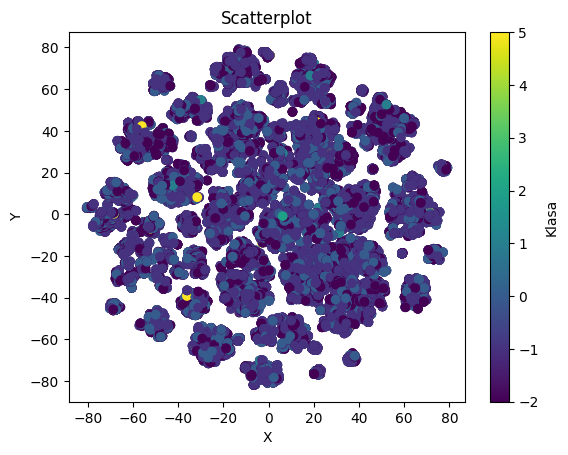

In [43]:
visualise_clusters(viz_pca_2d,2,last)

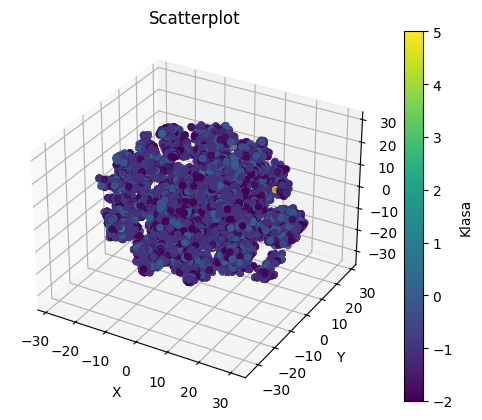

In [44]:
visualise_clusters(viz_pca_3d,3,last)

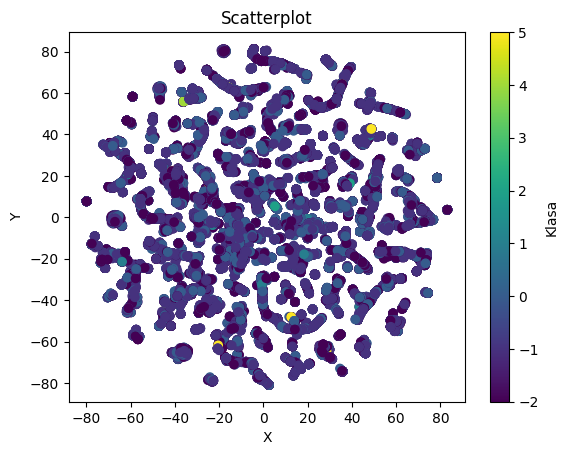

In [45]:
visualise_clusters(viz_lle_2d,2,last)

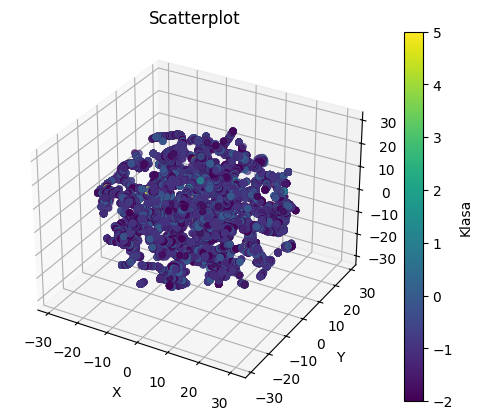

In [46]:
visualise_clusters(viz_lle_3d,3,last)

## Cluster

In [47]:
#KMeans, AffinityPropagation, MeanShift, SpectralClustering, AgglomerativeClustering, HDBSCAN
#GaussianMixture
def get_all_algs():
    algs = {'KM': KMeans(n_clusters=30, verbose=3), \
            'AC': AgglomerativeClustering(n_clusters=30, compute_distances=True), \
            'HD': HDBSCAN(n_jobs=-1),\
            'GM': GaussianMixture(verbose=3)}
    return algs

def train_algs(data, algs, get_preds=False):
    preds = [] 
    keys = list(algs.keys())
    for key in keys:
        try:
            print(key)
            print("------------------")
            p = algs[key].fit_predict(data)
            if get_preds: preds.append(p)
            print("------------------")
        except Exception as e:
            print(e)
    if get_preds:
        return preds

In [48]:
algs = get_all_algs()
preds_pca = train_algs(app_train_pca, algs, True)

KM
------------------
Initialization complete
Iteration 0, inertia 1084237.072172587.
Iteration 1, inertia 775895.5190835922.
Iteration 2, inertia 755575.1759954055.
Iteration 3, inertia 747300.166883765.
Iteration 4, inertia 742758.9466287857.
Iteration 5, inertia 737636.1404679312.
Iteration 6, inertia 722457.8726236874.
Iteration 7, inertia 715532.6710898749.
Iteration 8, inertia 711182.7233560239.
Iteration 9, inertia 711010.2913364035.
Iteration 10, inertia 710922.1929599532.
Iteration 11, inertia 710850.334340928.
Iteration 12, inertia 710761.2671191663.
Iteration 13, inertia 710726.6932555893.
Iteration 14, inertia 710712.5943231786.
Iteration 15, inertia 710711.2903874042.
Iteration 16, inertia 710711.0959035349.
Converged at iteration 16: strict convergence.


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 1085150.781775207.
Iteration 1, inertia 782304.5722344238.
Iteration 2, inertia 756201.1124513422.
Iteration 3, inertia 740416.9155151071.
Iteration 4, inertia 735007.709197002.
Iteration 5, inertia 734555.5563523895.
Iteration 6, inertia 734395.7299641721.
Iteration 7, inertia 734192.4317399594.
Iteration 8, inertia 733834.6359388668.
Iteration 9, inertia 733310.7701009478.
Iteration 10, inertia 733163.7164158891.
Iteration 11, inertia 733134.9899522758.
Iteration 12, inertia 733133.5297608624.
Converged at iteration 12: center shift 4.467280533080421e-05 within tolerance 0.00011774591842523062.
Initialization complete
Iteration 0, inertia 1065879.807007798.
Iteration 1, inertia 751402.3515405115.
Iteration 2, inertia 733580.6102572025.
Iteration 3, inertia 728332.0825598125.
Iteration 4, inertia 726192.6220735192.
Iteration 5, inertia 724016.8552813353.
Iteration 6, inertia 723445.1790527701.
Iteration 7, inertia 723227.7654084379.
Iterati

In [73]:
algs_lle = get_all_algs()
preds_lle = train_algs(app_train_lle,algs_lle,True)

KM
------------------
Initialization complete
Iteration 0, inertia 30.682664745801734.
Iteration 1, inertia 28.204860739830906.
Iteration 2, inertia 27.972412786216623.
Iteration 3, inertia 27.893316113071236.
Iteration 4, inertia 27.868852183528478.
Iteration 5, inertia 27.865284227344276.
Iteration 6, inertia 27.864377624239292.
Iteration 7, inertia 27.86410055719758.
Iteration 8, inertia 27.86394941026216.
Iteration 9, inertia 27.863906190175175.
Converged at iteration 9: center shift 1.0800416436091675e-09 within tolerance 2.743292579968088e-09.
Initialization complete
Iteration 0, inertia 30.522786209873694.
Iteration 1, inertia 27.993512908567542.
Iteration 2, inertia 27.763985440265735.
Iteration 3, inertia 27.718277123891.
Iteration 4, inertia 27.70778560339227.
Iteration 5, inertia 27.704587836228267.
Iteration 6, inertia 27.701234237633866.
Iteration 7, inertia 27.698500683662072.
Iteration 8, inertia 27.690302622964726.
Iteration 9, inertia 27.65105575987993.


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 10, inertia 27.635918367389934.
Iteration 11, inertia 27.633965248289336.
Iteration 12, inertia 27.633667866499398.
Iteration 13, inertia 27.63328023742181.
Iteration 14, inertia 27.631933153486685.
Iteration 15, inertia 27.63177914572102.
Iteration 16, inertia 27.63143495764764.
Iteration 17, inertia 27.631376696374403.
Converged at iteration 17: strict convergence.
Initialization complete
Iteration 0, inertia 30.538643311022817.
Iteration 1, inertia 28.518705191188474.
Iteration 2, inertia 28.323056630129315.
Iteration 3, inertia 28.286091347183827.
Iteration 4, inertia 28.26992283837632.
Iteration 5, inertia 28.266215755231322.
Iteration 6, inertia 28.25764370130006.
Iteration 7, inertia 28.251895654119178.
Iteration 8, inertia 28.24049293316999.
Iteration 9, inertia 28.23039971625898.
Iteration 10, inertia 28.19461198447376.
Iteration 11, inertia 28.191413938804107.
Iteration 12, inertia 28.191232925954296.
Iteration 13, inertia 28.19120044811544.
Iteration 14, inertia 28

## Visualize PCA

In [50]:
def visualize_all(data, dim, labels, names):
    for i in range(len(labels)):
        visualise_clusters(data,dim,labels[i], names[i])

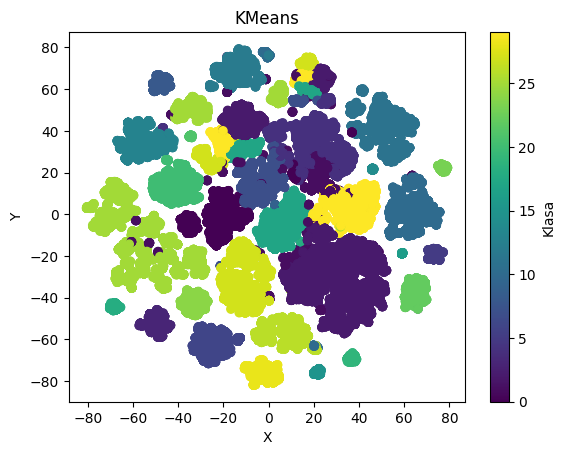

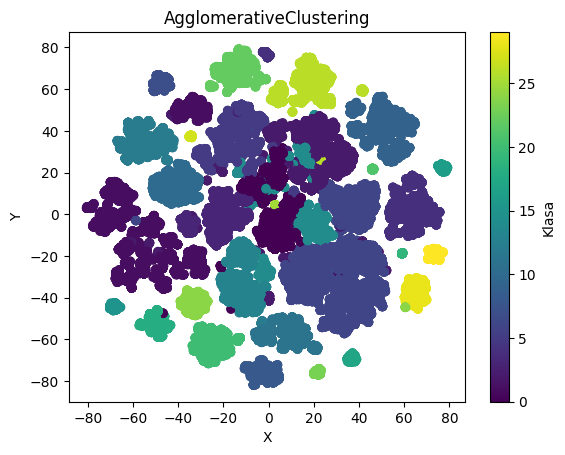

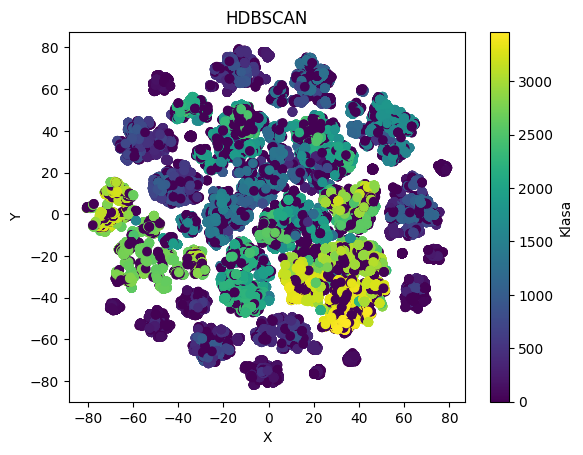

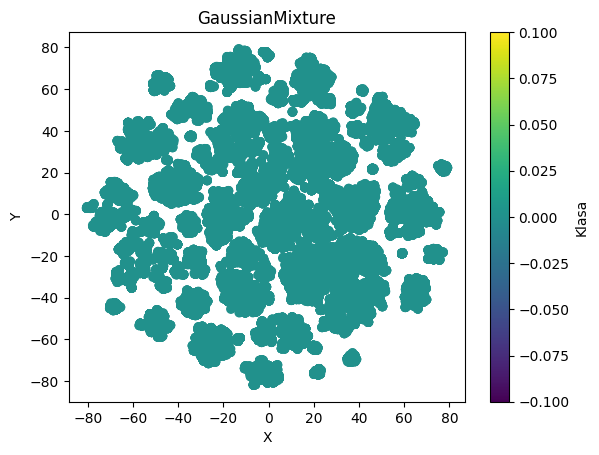

In [51]:
visualize_all(viz_pca_2d, 2, preds_pca, ['KMeans', 'AgglomerativeClustering', 'HDBSCAN', 'GaussianMixture'])

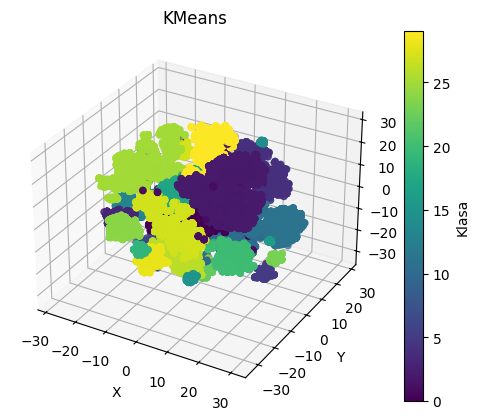

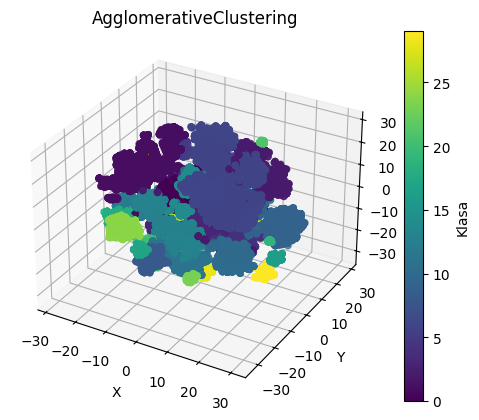

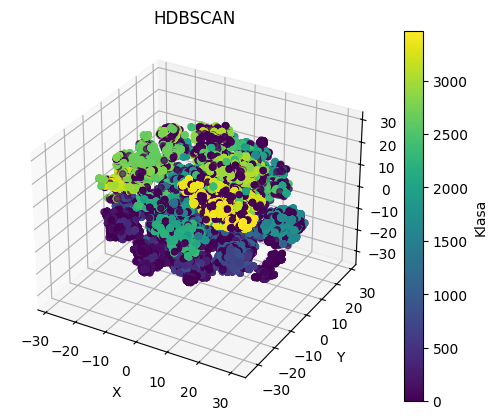

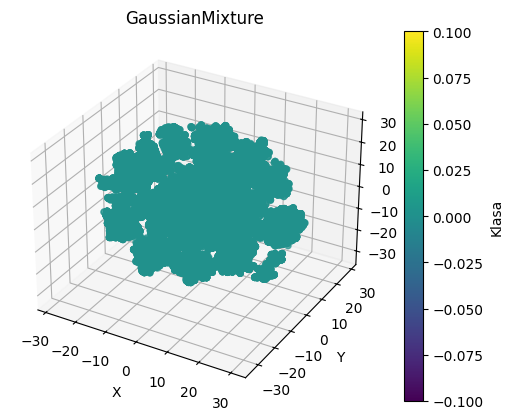

In [52]:
visualize_all(viz_pca_3d, 3, preds_pca, ['KMeans', 'AgglomerativeClustering', 'HDBSCAN', 'GaussianMixture'])

## Visualize LLE

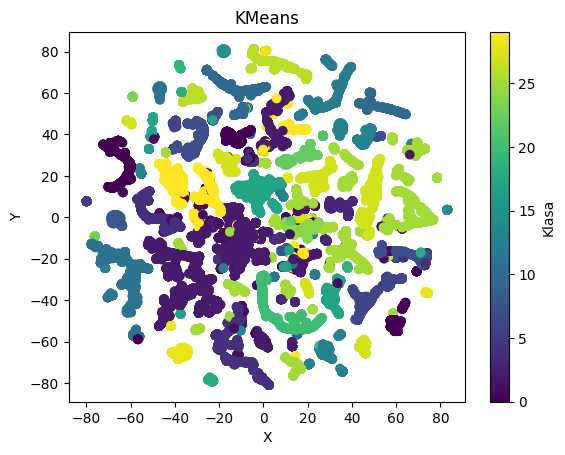

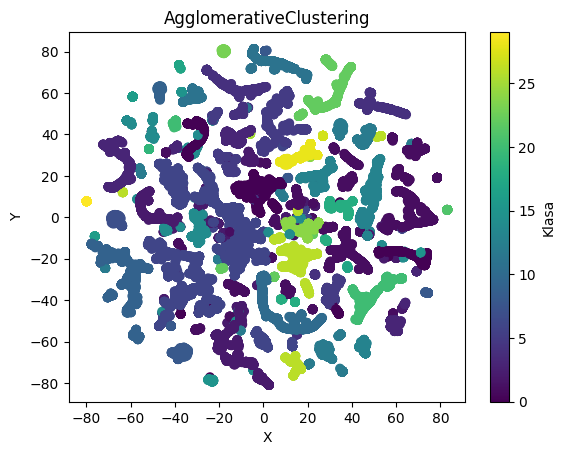

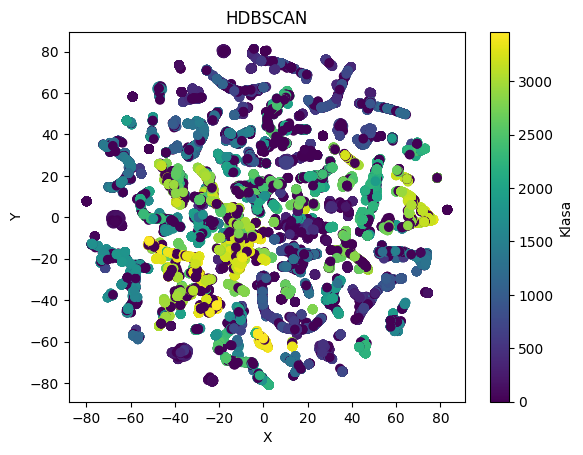

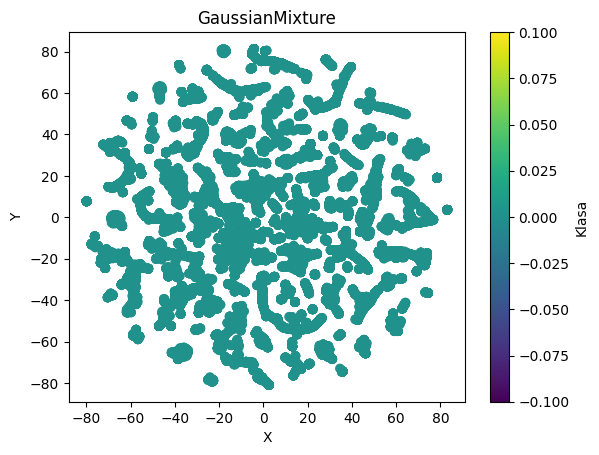

In [53]:
visualize_all(viz_lle_2d, 2, preds_pca, ['KMeans', 'AgglomerativeClustering', 'HDBSCAN', 'GaussianMixture'])

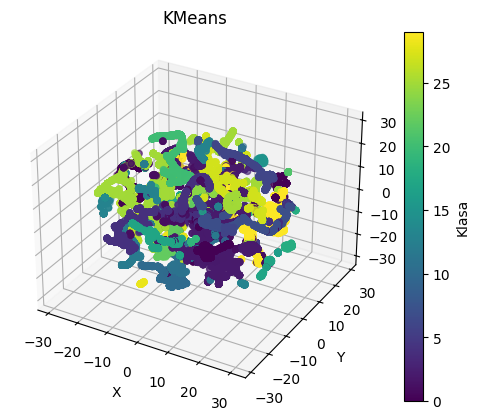

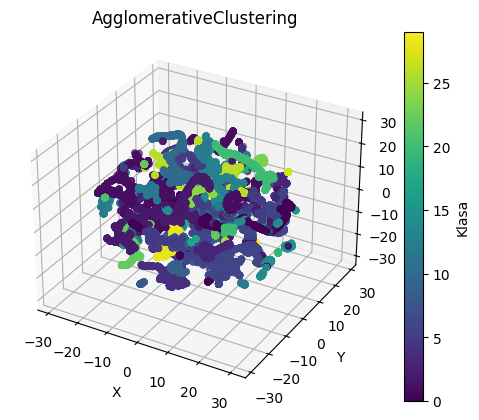

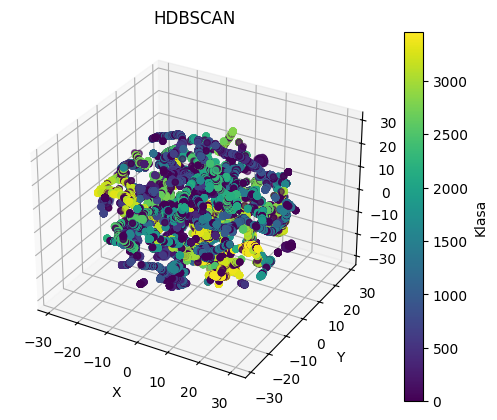

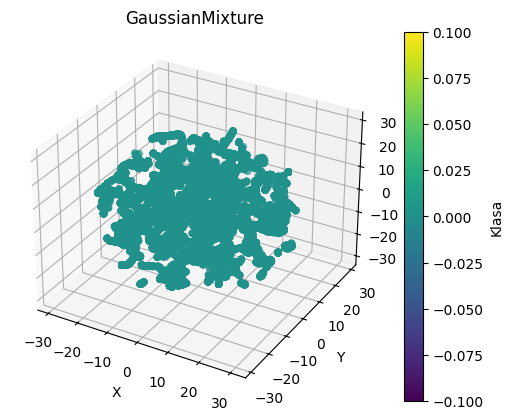

In [54]:
visualize_all(viz_lle_3d, 3, preds_pca, ['KMeans', 'AgglomerativeClustering', 'HDBSCAN', 'GaussianMixture'])

## KMeans Tune

C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  10 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  15 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  20 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  25 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  30 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  35 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  40 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  45 / 50


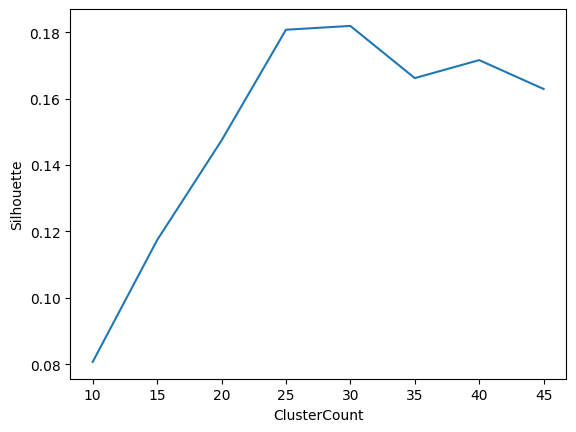

In [55]:
def silhouette_graph(data, min_k, max_k, step):
    rez = {}
    for i in range(min_k,max_k,step):
        km = KMeans(n_clusters=i)
        rez[i] = silhouette_score(data, km.fit_predict(data))
        print("Done: ", i, "/", max_k)
    df = pd.DataFrame(list(rez.items()), columns=['ClusterCount', 'Silhouette'])
    sns.lineplot(x='ClusterCount', y='Silhouette', data=df)

silhouette_graph(app_train_pca, 10, 50, 5)

C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  10 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  15 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  20 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  25 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  30 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  35 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  40 / 50


C:\Users\Danilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done:  45 / 50


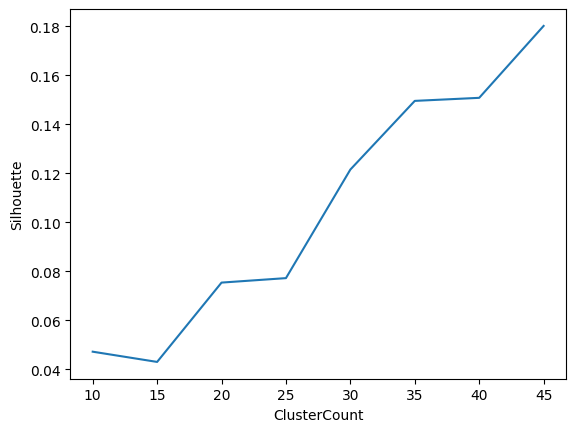

In [56]:
silhouette_graph(app_train_lle, 10, 50, 5)

## HDBSCAN

In [57]:
algs['HD'].labels_.max()

3461

In [58]:
algs_lle['HD'].labels_.max()

3589

## Agglomerative

In [59]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(algs['AC'], truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(algs_lle['AC'], truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

# Prediction

In [74]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier(n_estimators = 1000, n_jobs=-1)

In [75]:
preds_pca_T = np.transpose(np.array(preds_pca))
preds_lle_T = np.transpose(np.array(preds_lle))

In [81]:
preds_lle_T

array([[  18,   26,   -1,    0],
       [  24,   20, 2169,    0],
       [  24,   20, 2169,    0],
       ...,
       [  18,   12,  779,    0],
       [   5,   12, 1949,    0],
       [  17,   23,  204,    0]], dtype=int64)

In [82]:
#preds_pca, preds_lle
#avg, last
k=0.2
test_len = int(k * len(preds_pca_T))
train_pca, test_pca = preds_pca_T[test_len:], preds_pca_T[:test_len]
train_lle, test_lle = preds_lle_T[test_len:], preds_lle_T[:test_len]
avg_train, avg_test = avg[test_len:], avg[:test_len] 
last_train, last_test = last[test_len:], last[:test_len] 

In [78]:
etc.fit(train_pca, avg_train)
print("PCA+AVG: ", etc.score(test_pca,avg_test))

PCA+AVG:  0.7131633356305996


In [79]:
etc.fit(train_pca, last_train)
print("PCA+LAST: ", etc.score(test_pca,last_test))

PCA+LAST:  0.42067539627842865


In [83]:
etc.fit(train_lle, avg_train)
print("LLE+AVG: ", etc.score(test_lle,avg_test))

LLE+AVG:  0.7135768435561681


In [84]:
etc.fit(train_lle, last_train)
print("LLE+LAST: ", etc.score(test_lle,last_test))

LLE+LAST:  0.39972432804962094
